In [1]:
#General Imports
import math
import numpy as np 
import matplotlib.pyplot as plt
import pylab as pl


#ScikitLearn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.svm import SVC 

#Qiskit imports
from qiskit import QuantumCircuit, Aer,QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.visualization import plot_histogram

from utils2 import *

import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'


SEED = 1430


# MNIST Dataset

In [2]:
# dataset is made up of 1797 8x8 images (https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html)
mnist = datasets.load_digits()

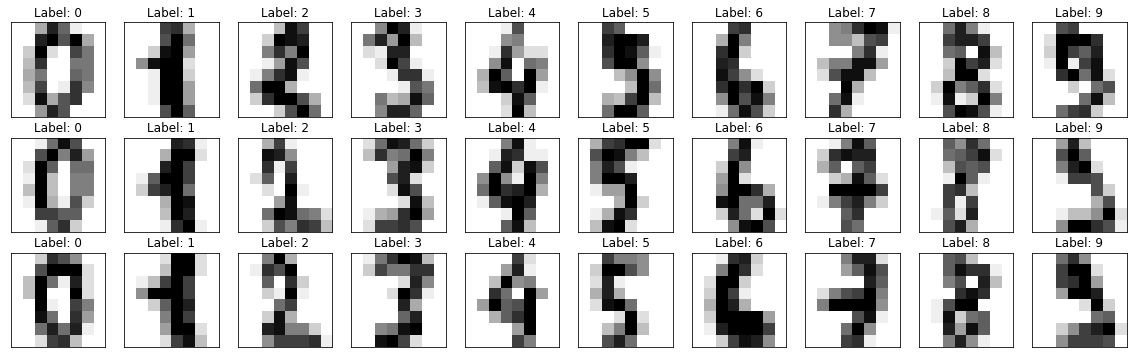

In [3]:
show_images(mnist.images, mnist.target)

In [4]:
# Filter digits and targets
labels = [0, 3]
x = mnist.images[[t in labels for t in mnist.target]]
y = mnist.target[[t in labels for t in mnist.target]]

# We keep only 24 images for each label
class_size = 24
x0 = x[y == labels[0]][:class_size:]
x1 = x[y == labels[1]][:class_size:]

In [5]:
# 80-20 split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
labels = np.array([0]*class_size + [1]*class_size)

x_train_full_scale, x_test_full_scale, y_train, y_test = train_test_split(np.concatenate((x0, x1), axis=0), labels, test_size=0.2, random_state=SEED, stratify=labels)

print(f'Size of the train set: {len(x_train_full_scale)}\nSize of the test set: {len(x_test_full_scale)}')

Size of the train set: 38
Size of the test set: 10


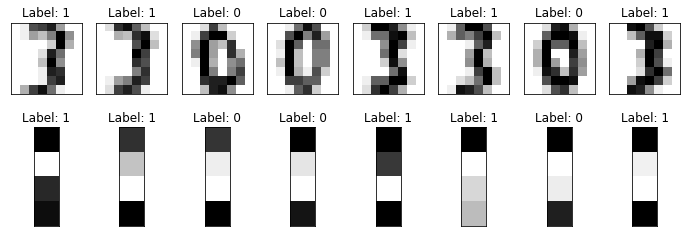

In [6]:
# https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
x_train = np.vstack([[resize(x_i, (4,1), anti_aliasing=False) for x_i in x_train_full_scale]])
x_test = np.vstack([[resize(x_i, (4,1), anti_aliasing=False) for x_i in x_test_full_scale]])

num_samples = 8
sources = [x_train_full_scale, x_train]
fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(12, 4))
for i in range(num_samples):
    for s in range(len(sources)):
        axes[s, i].imshow(sources[s][i,:,:], cmap=plt.cm.gray_r)
        axes[s, i ].set_xticks([])
        axes[s, i].set_yticks([])
        axes[s, i].set_title(f"Label: {y_train[i]}")

In [7]:
# Reshape input data size from (4,1) to (4,)
x_train = x_train.reshape(x_train.shape[:-1])
x_test = x_test.reshape(x_test.shape[:-1])



# Angle encoding


In [8]:
nb_features = x_train.shape[1] # determines feature space dimension

x_params = [Parameter(f'x{str(i)}') for i in range(nb_features)]

def angle_encoding(nb_features_func):
       
    """
    Qubit - or rotation - encoding in RX gates.

    :param qc: The quantum circuit.
    :param nb_features: The number of features of the feature vector. 
    :return: The quantum circuit with the encoding layer. 
    """
    
    qc = QuantumCircuit(nb_features_func) # number of qubits = number of features

    for i in range(nb_features_func):
        qc.rx(x_params[i], i)

        
    return qc 

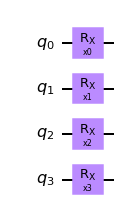

In [9]:
qc = angle_encoding(nb_features) # Encode data for each point as Rx unitary rotation
qc.draw('mpl')

Features for the first datapoint: [9.5  4.75 8.75 9.25]


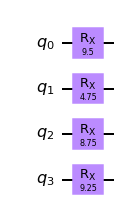

In [10]:
print('Features for the first datapoint:', x_train[0])

qc = qc.assign_parameters(x_train[0]) #data becomes parameters
qc.draw('mpl')

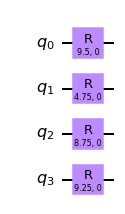

In [11]:
qc.decompose().draw('mpl')

# Parametrized feature maps

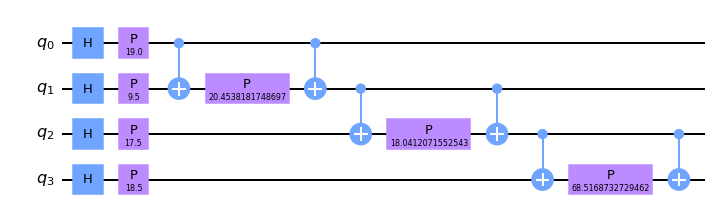

In [12]:
map_z = ZZFeatureMap(feature_dimension=nb_features, reps=1, entanglement= "linear")
encode_circuit = map_z.assign_parameters(x_train[0])
encode_circuit.decompose().draw(output='mpl')

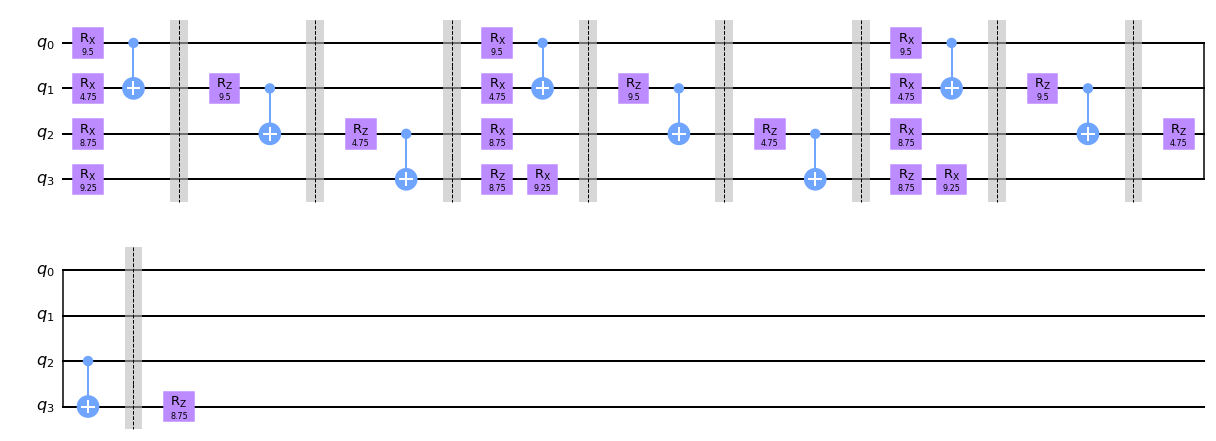

In [13]:
# Modify this function to customize the circuit
def get_cicuit(n_qubits,n_layer, input_data):
    qc = QuantumCircuit(n_qubits)
    for layer in range(n_layer):
        for i in range(nb_features):
            qc.rx(input_data[i], i)
        for i in range(n_qubits - 1):
            qc.cx(i, i+1)
            qc.barrier()
            qc.rz(input_data[i], i+1)
    return qc

qc = get_cicuit(n_qubits = nb_features, n_layer = 3, input_data = x_train[0])
qc.draw('mpl')

# Evaluating a kernel using simulator

In [14]:
#Defining a quantum instance
simulator = Aer.get_backend('qasm_simulator')
shots = 1024
qinst = QuantumInstance(simulator, shots, SEED)

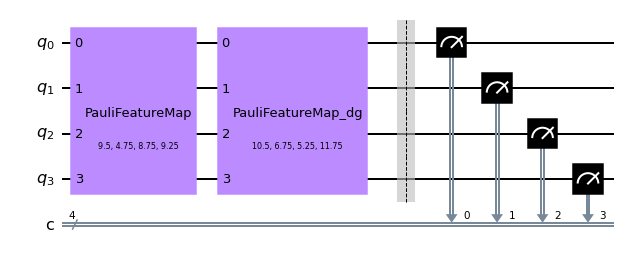

In [15]:
pauli_map = PauliFeatureMap(feature_dimension=nb_features, reps=1, entanglement='linear')

#Building the kernel matrix
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=qinst)

#Constructing the inner product circuit for given datapoints and feature map
pauli_circuit = pauli_kernel.construct_circuit(x_train[0], x_train[1])

pauli_circuit.decompose().draw('mpl')

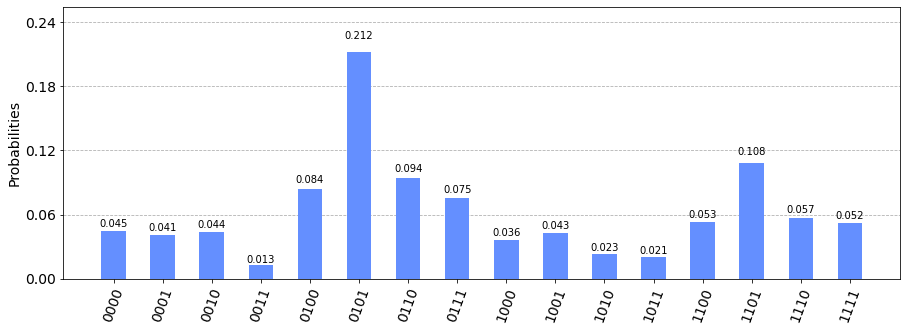

In [16]:
job = execute(pauli_circuit, backend = simulator, shots=shots)
counts = job.result().get_counts(pauli_circuit)
plot_histogram(counts, figsize=(15,5))

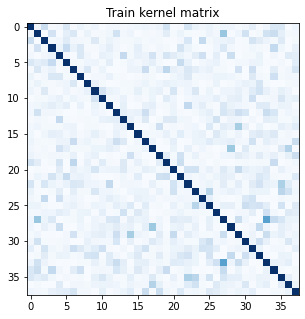

In [17]:
train_matrix= pauli_kernel.evaluate(x_vec=x_train)
test_matrix = pauli_kernel.evaluate(x_vec=x_test, y_vec=x_train)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

# SVC

In [18]:
model = SVC(kernel= pauli_kernel.evaluate)
y_train

#Fiting the SVM model according to the given training data.
model.fit(x_train, y_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f46bf887f10>>)

In [19]:
score = model.score(x_test, y_test)
print(f'Callable kernel classification test score: {score}')

Callable kernel classification test score: 0.3


# Evaluating a kernel using real quantum computer

In [20]:
# run on real quantum computer

IBMQ.save_account(open("/home/aaltintas/Dropbox/quantum-computing/IBM/useIBMlocally.txt").read())

configrc.store_credentials:WARNING:2022-01-30 20:40:08,525: Credentials already present. Set overwrite=True to overwrite.


In [21]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [22]:
qc_providers = IBMQ.get_provider(hub='ibm-q-education',group='qscitech-quantum',project='qc-bc-workshop')

In [23]:
qc_get_computer = qc_providers.get_backend('ibmq_jakarta')

In [24]:
shots = 1024
qinst = QuantumInstance(qc_get_computer, shots, SEED)

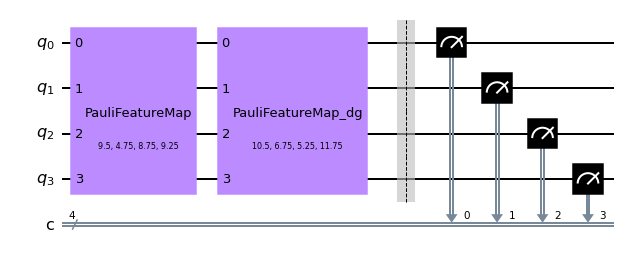

In [25]:
pauli_map = PauliFeatureMap(feature_dimension=nb_features, reps=1, entanglement='linear')

#Building the kernel matrix
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=qinst)

#Constructing the inner product circuit for given datapoints and feature map
pauli_circuit = pauli_kernel.construct_circuit(x_train[0], x_train[1])

pauli_circuit.decompose().draw('mpl')

In [26]:
# watch job status

import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor

%qiskit_job_watcher
job = classify(qinst, pauli_circuit)
job_monitor(job)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

NameError: name 'classify' is not defined

In [ ]:
# plot results of computation
counts = job.result().get_counts(pauli_circuit)
plot_histogram(counts, figsize=(15,5))

In [ ]:
train_matrix= pauli_kernel.evaluate(x_vec=x_train)
test_matrix = pauli_kernel.evaluate(x_vec=x_test, y_vec=x_train)

fig, axs = plt.subplots(1, figsize=(10, 5))
axs.imshow(
    np.asmatrix(train_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs.set_title("Train kernel matrix")
plt.show()

In [ ]:
model = SVC(kernel= pauli_kernel.evaluate)
y_train

#Fiting the SVM model according to the given training data.
model.fit(x_train, y_train)

In [ ]:
score = model.score(x_test, y_test)
print(f'Callable kernel classification test score: {score}')